In [1]:
import math
import itertools

import pandas as pd
from sqlalchemy.sql import select

from predict_aqi.load_data import (
    AirLocation, get_db_session, load_air_location_data, load_measurement_data,
)

# Select some airlocation with bad aqi
session = get_db_session()
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_ids = [x['id'] for x in session.execute(s)]

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [2]:
# Select classifier to use
from sklearn.neural_network import MLPRegressor
from predict_aqi.single_city_model import generate_AQI_inputs_and_outputs
from predict_aqi import config
from predict_aqi.transform_data import clean_data


def load_data_for_airlocation(airlocation_id):
    indices_ahead_to_predict = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 2)
    indices_behind_to_use = range(1, MAX_INDEX)
    some_airlocation = load_air_location_data(airlocation_id)
    
    print("Loading {}, {}".format(some_airlocation.short_name, some_airlocation.en_country_name))
    
    measurements = load_measurement_data(airlocation_id)
    df, input_columns, output_columns = generate_AQI_inputs_and_outputs(
        measurements, indices_behind_to_use, indices_ahead_to_predict
    )
    return clean_data(df, input_columns), input_columns, output_columns

In [3]:
from predict_aqi.single_city_model import (
    generate_predictions_two_step, generate_predictions_one_step, 
    get_first_step_functions, get_second_step_functions,
    get_one_step_functions
)
from sklearn.metrics import mean_absolute_error
import copy

MAX_INDEX = 48
INDICES_BEHIND_TO_USE_RANGE = range(1, MAX_INDEX + 1, 16)
INDICES_AHEAD_TO_PREDICT = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 2)


def generate_errors_for_airlocation_predictions(
        df, 
        input_columns, 
        output_columns, 
        first_step_regressor_params,
        second_step_regressor_params,
        one_step_regressor_params):
    
    row_count = df.count()[0]
    split_row = int(round(row_count * 0.90))
    
    errors = {}
    
    for indices_behind_to_use_index in INDICES_BEHIND_TO_USE_RANGE:
        current_input_columns = copy.deepcopy(input_columns[:indices_behind_to_use_index])
        first_step_format_inputs_outputs, first_step_split_function = get_first_step_functions(
            current_input_columns, output_columns
        )
        second_step_format_inputs_outputs, second_step_split_function = get_second_step_functions(
            current_input_columns, output_columns, INDICES_AHEAD_TO_PREDICT
        )
        one_step_format_inputs_outputs, one_step_split_function = get_one_step_functions(
            current_input_columns, output_columns
        )
        
        first_step_regressor = MLPRegressor(**first_step_regressor_params)
        second_step_regressors = [MLPRegressor(**second_step_regressor_params) for i in INDICES_AHEAD_TO_PREDICT]
        one_step_regressors = [MLPRegressor(**one_step_regressor_params) for i in INDICES_AHEAD_TO_PREDICT]
        
        this_iteration_df = df.copy(deep=True)
        this_iteration_df = generate_predictions_two_step(
            this_iteration_df,
            first_step_format_inputs_outputs,
            first_step_split_function,
            second_step_format_inputs_outputs,
            second_step_split_function,
            first_step_regressor,
            second_step_regressors,
            INDICES_AHEAD_TO_PREDICT,
            False
        )
        
        this_iteration_df = generate_predictions_one_step(
            this_iteration_df,
            one_step_format_inputs_outputs,
            one_step_split_function,
            one_step_regressors,
            INDICES_AHEAD_TO_PREDICT,
            False
        )
        
        this_iteration_error_dict = {'first_step': {}, 'second_step': {}, 'one_step': {}, 'baseline': {}}
        for i in INDICES_AHEAD_TO_PREDICT:
            this_iteration_error_dict['first_step'][i] = mean_absolute_error(
                this_iteration_df['{}_ahead_AQI'.format(i)][split_row:], 
                this_iteration_df['{}_ahead_first_step_pred'.format(i)][split_row:]
            )
            this_iteration_error_dict['second_step'][i] = mean_absolute_error(
                this_iteration_df['{}_ahead_AQI'.format(i)][split_row:], 
                this_iteration_df['{}_ahead_second_step_pred'.format(i)][split_row:]
            )
            this_iteration_error_dict['one_step'][i] = mean_absolute_error(
                this_iteration_df['{}_ahead_AQI'.format(i)][split_row:], 
                this_iteration_df['{}_ahead_one_step_pred'.format(i)][split_row:]
            )
            
            baseline_col = '{}_ahead_baseline_pred'.format(i)
            this_iteration_df[baseline_col] = this_iteration_df[baseline_col].apply(lambda x: x / 300)
            this_iteration_error_dict['baseline'][i] = mean_absolute_error(
                this_iteration_df['{}_ahead_AQI'.format(i)][split_row:], 
                this_iteration_df[baseline_col][split_row:]
            )
        errors[indices_behind_to_use_index] = this_iteration_error_dict
        del this_iteration_df
    return errors

In [4]:
import matplotlib.pyplot as plt


def generate_error_graph(errors):
    first_step_errors = {
        i: [errors[i]['first_step'][key] * config.MAX_AQI 
            for key in sorted(errors[i]['first_step'].keys())]
        for i in INDICES_BEHIND_TO_USE_RANGE
    }
    
    second_step_errors = {
        i: [errors[i]['second_step'][key] * config.MAX_AQI 
            for key in sorted(errors[i]['second_step'].keys())]
        for i in INDICES_BEHIND_TO_USE_RANGE
    }
    
    one_step_errors = {
        i: [errors[i]['one_step'][key] * config.MAX_AQI 
            for key in sorted(errors[i]['one_step'].keys())]
        for i in INDICES_BEHIND_TO_USE_RANGE
    }
    
    baseline_errors = {
        i: [errors[i]['baseline'][key] * config.MAX_AQI
            for key in sorted(errors[i]['baseline'].keys())]
        for i in INDICES_BEHIND_TO_USE_RANGE
    }
    plt.figure(figsize=(15, 10))
    #plt.axis([0.0, 25.0, 0.0, 45.0])
    distances = sorted(first_step_errors.keys())
    for distance in distances:
        plt.plot(
            [d // 2 for d in INDICES_AHEAD_TO_PREDICT], 
            first_step_errors[distance], 
            label="{}hrs input first step error".format(distance / 2),
            color=str(distance / (max(distances) + 2))
        )
        plt.plot(
            [d // 2 for d in INDICES_AHEAD_TO_PREDICT],
            second_step_errors[distance], 
            label="{}hrs input second step error".format(distance / 2),
            color=str(distance / (max(distances) + 2))
        )
        plt.plot(
            [d // 2 for d in INDICES_AHEAD_TO_PREDICT],
            one_step_errors[distance], 
            label="{}hrs input one step error".format(distance / 2),
            color=str(distance / (max(distances) + 2))
        )
        plt.plot(
            [d // 2 for d in INDICES_AHEAD_TO_PREDICT],
            baseline_errors[distance], 
            label="{}hrs input baseline error".format(distance / 2),
            color="Red"
        )
    plt.legend(loc=6, bbox_to_anchor=(0.5, 0))
    plt.suptitle("Absolute AQI error on predictions for the next 24 hours", fontsize=20)
    return first_step_errors, second_step_errors, one_step_errors, baseline_errors

In [5]:
from predict_aqi.transform_data import generate_baseline_predictions
import datetime

start = datetime.datetime.now()

all_errors = []
NUMBER_OF_CITIES_TO_TEST = 4

hidden_layer_sizes = (100, 10)
alpha = 0.0001
#for hidden_layer_sizes in [(100,), (100,10), (100, 50, 10), (300,), (300, 10), (300, 50, 10)]:
#for alpha in [0.1, 0.001, 0.0001, 0.00001]:
for airlocation_id in some_airlocation_ids[0:NUMBER_OF_CITIES_TO_TEST]:
    df, input_columns, output_columns = load_data_for_airlocation(airlocation_id)
    df = generate_baseline_predictions(df, output_columns)
    if df.count()[0] < 1000:
        # not enough data to train on
        continue
    regressor_params = {'alpha': alpha, 'hidden_layer_sizes': hidden_layer_sizes}
        
    errors = generate_errors_for_airlocation_predictions(
        df, input_columns, output_columns, regressor_params, regressor_params, regressor_params
    )
    first_step_errors, second_step_errors, one_step_errors, baseline_errors = generate_error_graph(errors)
    all_errors.append((first_step_errors, second_step_errors, one_step_errors, baseline_errors))
    del df
end = datetime.datetime.now()
print("Took {} seconds".format((end - start).total_seconds()))

Distance into the past of inputs used: 0.5hrs
Sum of absolute first step AQI prediction error: 798.0967177428432
Sum of absolute second step AQI prediction error: 767.5045117527001
Sum of absolute one step AQI prediction error: 808.0996525085473
Sum of absolute baseline AQI prediction error: 1192.075
Distance into the past of inputs used: 8.5hrs
Sum of absolute first step AQI prediction error: 790.0621976731281
Sum of absolute second step AQI prediction error: 751.2184700253334
Sum of absolute one step AQI prediction error: 782.8371302648741
Sum of absolute baseline AQI prediction error: 1192.075
Distance into the past of inputs used: 16.5hrs
Sum of absolute first step AQI prediction error: 726.9260075316753
Sum of absolute second step AQI prediction error: 752.0588724856011
Sum of absolute one step AQI prediction error: 772.3607226647263
Sum of absolute baseline AQI prediction error: 1192.075


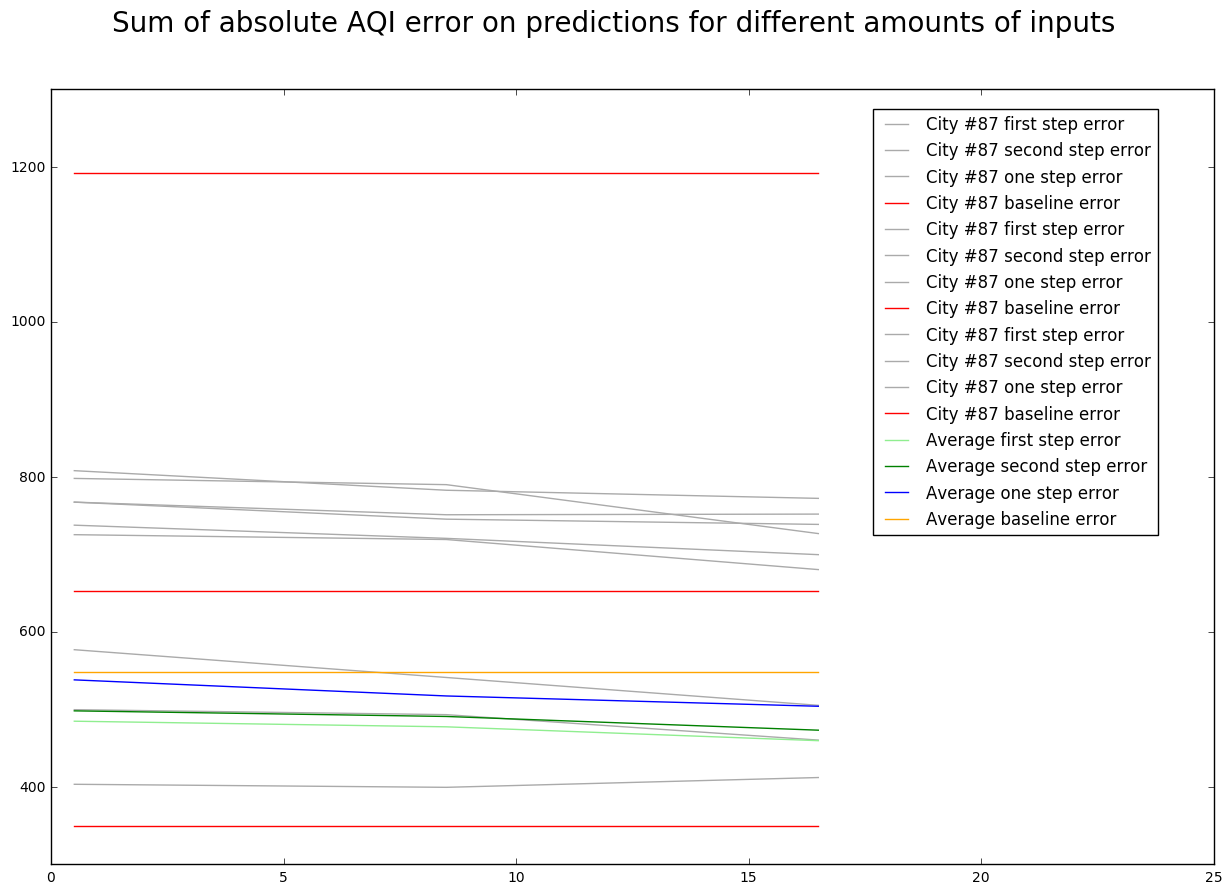

In [30]:
plt.figure(figsize=(15, 10))
plt.axis([0.0, 25.0, 300.0, 1300.0])
all_city_average_errors = {
    'first_step_error': [0 for i in INDICES_BEHIND_TO_USE_RANGE],
    'second_step_error': [0 for i in INDICES_BEHIND_TO_USE_RANGE],
    'one_step_error': [0 for i in INDICES_BEHIND_TO_USE_RANGE],
    'baseline_error': [0 for i in INDICES_BEHIND_TO_USE_RANGE],
}
xs = [d / 2 for d in INDICES_BEHIND_TO_USE_RANGE]
for index, (first_step_errors, second_step_errors, one_step_errors, baseline_errors) in enumerate(all_errors):
    first_step_ys = [sum(first_step_errors[d]) for d in INDICES_BEHIND_TO_USE_RANGE]
    for index, error in enumerate(first_step_ys):
        all_city_average_errors['first_step_error'][index] += error / NUMBER_OF_CITIES_TO_TEST
    plt.plot(
        xs, 
        first_step_ys,
        label="City #{} first step error".format(some_airlocation_ids[index]),
        color=str(index / len(all_errors))
    )
    
    second_step_ys = [sum(second_step_errors[d]) for d in INDICES_BEHIND_TO_USE_RANGE]
    for index, error in enumerate(second_step_ys):
        all_city_average_errors['second_step_error'][index] += error / NUMBER_OF_CITIES_TO_TEST
    plt.plot(
        xs,
        second_step_ys,
        label="City #{} second step error".format(some_airlocation_ids[index]),
        color=str(index / len(all_errors))
    )
    
    one_step_ys = [sum(one_step_errors[d]) for d in INDICES_BEHIND_TO_USE_RANGE]
    for index, error in enumerate(one_step_ys):
        all_city_average_errors['one_step_error'][index] += error / NUMBER_OF_CITIES_TO_TEST
    plt.plot(
        xs,
        one_step_ys,
        label="City #{} one step error".format(some_airlocation_ids[index]),
        color=str(index / len(all_errors))
    )
    
    baseline_ys = [sum(baseline_errors[d]) for d in INDICES_BEHIND_TO_USE_RANGE]
    for index, error in enumerate(baseline_ys):
        all_city_average_errors['baseline_error'][index] += error / NUMBER_OF_CITIES_TO_TEST
    plt.plot(
        xs,
        baseline_ys,
        label="City #{} baseline error".format(some_airlocation_ids[index]),
        color="Red"
    )

plt.plot(
    xs, 
    all_city_average_errors['first_step_error'],
    label="Average first step error",
    color="LightGreen"
)
plt.plot(
    xs, 
    all_city_average_errors['second_step_error'],
    label="Average second step error",
    color="Green"
)
plt.plot(
    xs, 
    all_city_average_errors['one_step_error'],
    label="Average one step error",
    color="Blue"
)
plt.plot(
    xs, 
    all_city_average_errors['baseline_error'],
    label="Average baseline error",
    color="Orange"
)

plt.legend(loc=6, bbox_to_anchor=(0.7, 0.7))
plt.suptitle("Sum of absolute AQI error on predictions for different amounts of inputs", fontsize=20)


y = [sum(first_step_errors[d]) for d in sorted(first_step_errors.keys())]
for distance in sorted(first_step_errors.keys()):
    print("Distance into the past of inputs used: {}hrs".format(distance / 2))
    print("Sum of absolute first step AQI prediction error: {}".format(
        sum(first_step_errors[distance])
    ))
    print("Sum of absolute second step AQI prediction error: {}".format(
        sum(second_step_errors[distance])
    ))
    print("Sum of absolute one step AQI prediction error: {}".format(
        sum(one_step_errors[distance])
    ))
    print("Sum of absolute baseline AQI prediction error: {}".format(
        sum(baseline_errors[distance])
    ))